In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np

import matplotlib.pyplot as plt
import time
import os
import copy


plt.ion()

In [2]:
import torchvision
from torchvision import datasets, models, transforms

In [3]:

import os

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_folder_path = "C:/project 22"

In [6]:

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(
        data_folder_path,
            x
        ),
        data_transforms[x]
    ) for x in ["train", "test"]
}

In [7]:

dataloaders = {
    x: torch.utils.data.DataLoader(
    image_datasets[x],
    shuffle=True,
    batch_size=4,
        num_workers=4
) for x  in ["train", "test"]
}

In [8]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x197463187c0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x19746351130>}

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
dataset_sizes

{'train': 256, 'test': 120}

In [10]:

class_names = image_datasets['train'].classes
class_names

['train']

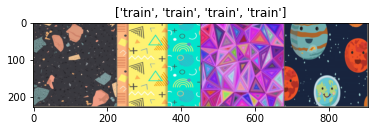

In [11]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:

device = "cpu" if not torch.cuda.is_available() else "cuda"

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0768 Acc: 0.9688
test Loss: 0.0000 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0001 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.0000 Acc: 1.0000
test Loss: 0.0001 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.0000 Acc: 1.0000
test Loss: 0.0000 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0001 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0001 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0001 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0000 Acc: 1.0000
test Loss: 0.0001 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0001 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0001 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0000 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0000 Acc: 1.0000
test Loss: 0.0001 Acc